In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
import os
import torch
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
from utils import get_bigbench_tasks

all_tasks = get_bigbench_tasks()

# examined by the equation used in bigbench paper and eyeballing the results
fewshot_Btasks = "bigbench__codelinedescription, bigbench__humanorganssenses, bigbench__implicatures, bigbench__phraserelatedness, bigbench__whatisthetao, bigbench__swahilienglishproverbs".split(", ")
fewshot_Ltasks = "bigbench__dateunderstanding, bigbench__hhhalignment, bigbench__fantasyreasoning, bigbench__implicitrelations, bigbench__intentrecognition, bigbench__figureofspeechdetection, bigbench__similaritiesabstraction, bigbench__simpleethicalquestions, bigbench__strangestories, bigbench__undopermutation, bigbench__misconceptions, bigbench__nonsensewordsgrammar".split(", ")

In [6]:
# load bigbench results

from utils import load_bigbench_random_performance, reorganize_option_ppl 
shot = 2

task_type = "breakthrough_tasks" # breakthrough_tasks; linearity_tasks; all_tasks
if task_type == "breakthrough_tasks":
    tasks = fewshot_Btasks
elif task_type == "linearity_tasks":
    tasks = fewshot_Ltasks
else:
    tasks = all_tasks 

# format: {model: {"accuracy": {task: {step: acc}}, "flops": {step: flop}, "tokens": {step: token}}}
if task_type == "all_tasks":
    outfile = "data/bigbench/checkpoint_results.pt"
elif task_type == "linearity_tasks":
    outfile = "data/bigbench/checkpoint_Ltasks_results.pt"
else:
    outfile = "data/bigbench/checkpoint_Btasks_results.pt"
    
result = torch.load(outfile)
for model in result:
    for task in list(result[model]["accuracy"].keys()):
        if task not in tasks:
            del result[model]["accuracy"][task]

random_result = np.mean([load_bigbench_random_performance(task) for task in tasks])

log_mode = True

all_correct_ppls, correct_option_ppls, incorrect_option_ppls = reorganize_option_ppl(tasks)


### plot accuracy vs. validation perplexity

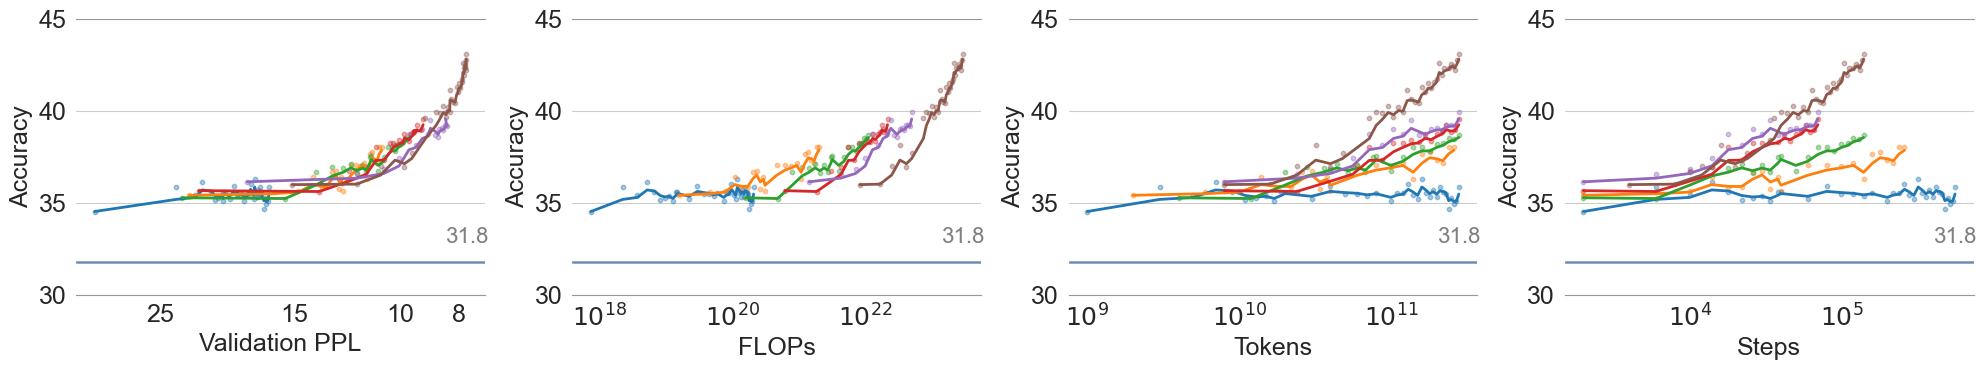

In [9]:
# plot accuracy vs. validation ppl, flops, tokens, steps

from utils import return_checkpoint_index, load_opt_validation_ppl, exponential_moving_average
validation_ppl = load_opt_validation_ppl()

colors = [plt.cm.tab20(i) for i in range(20)]
sns.set_style("whitegrid")

plot_types = ["Validation PPL", "FLOPs", "Tokens", "Steps"]
    
fig, axes = plt.subplots(1, len(plot_types), figsize=(5 * len(plot_types), 3.8))
fontsize = 18
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)

for plot_type_id, plot_type in enumerate(plot_types):
    max_x = 0 if plot_type != "Validation PPL" else 1e18
    ax = axes if len(plot_types) == 1 else axes[plot_type_id]
    if plot_type == "Validation PPL":
        ax.invert_xaxis()
        
    for model_id, model_size in enumerate(result):
        xs = []; ys = []
        indexes = return_checkpoint_index(model_size)
        
        if plot_type == "FLOPs":
            xs = [result[model_size]["flops"][i] for i in indexes]
        elif plot_type == "Tokens":
            xs = [result[model_size]["tokens"][i] for i in indexes]
        elif plot_type == "Validation PPL":
            xs = [validation_ppl[model_size]["valid/combined"][i] for i in indexes]
        else:
            xs = indexes
        
        accuracy = result[model_size]["accuracy"]
        all_ys = np.zeros((len(accuracy), len(indexes)))
        for k, task in enumerate(accuracy):
            for j, index in enumerate(indexes):
                if index in accuracy[task]:
                    all_ys[k][j] = accuracy[task][index]
                else:
                    all_ys[k][j] = -1

        filter_out_ckpts = (all_ys == -1).any(0)
        xs = np.array(xs)[~filter_out_ckpts]
        all_ys = all_ys[:, ~filter_out_ckpts]

        ys = all_ys.mean(0)    
        if log_mode: xs = np.log10(xs)
        ema_ys = exponential_moving_average(ys, 0.5)
        ax.axhline(y=random_result, linewidth=1, label='Random', color="#708cb2")

        # get the position to plot the random performnace
        func = min if plot_type == "Validation PPL" else max
        max_x = func(max_x, func(xs))
        
        ax.plot(xs, ema_ys, label=model_size, color=colors[model_id*2], linewidth=2)
        ax.scatter(xs, ys, marker="o", alpha=0.4, color=colors[model_id*2], s=10)
        ax.set_xlabel(plot_type, fontsize=fontsize)
        ax.set_ylabel("Accuracy", fontsize=fontsize)
        
        if model_id == 0:
            if plot_type == "Validation PPL": #  or type == "PPL of Options PPL":
                xs_ppl = [7, 8, 10, 15, 25]
                ax.set_xticks([np.log10(x) for x in xs_ppl], xs_ppl)
            if plot_type == "FLOPs":
                ax.set_xticks([18, 20, 22], ['$10^{18}$', '$10^{20}$', '$10^{22}$'], fontsize=fontsize)
            if plot_type == "Tokens":
                ax.set_xticks([9, 10, 11], ['$10^{9}$', '$10^{10}$', '$10^{11}$'], fontsize=fontsize)
            if plot_type == "Steps":
                ax.set_xticks([4, 5], ['$10^{4}$', '$10^{5}$'], fontsize=fontsize)
            if task_type == "all_tasks":
                ax.set_ylim([30, 45])
        
        ax.yaxis.grid(True)
        sns.despine(left=True, bottom=False, top=False)
        ax.spines['top'].set_color('#989898')
        ax.spines['bottom'].set_color('#989898')
        ax.xaxis.grid(False)
    ax.annotate(round(random_result, 1), (max_x, random_result + 1), fontsize=fontsize-2, horizontalalignment="center", color=colors[14])

if task_type == "breakthrough_tasks":
    figure_title = "Breakthroughness Tasks"
elif task_type == "linearity_tasks":
    figure_title = "Linearity Tasks"
else:
    figure_title = "All Tasks"

# fig.suptitle(figure_title, fontsize=fontsize)

plt.tight_layout()
plt.savefig(f"images/bigbench_{'_'.join(figure_title.lower().split())}.pdf")

### Plot option perplexity against validation perplexity, flops and steps, tokens

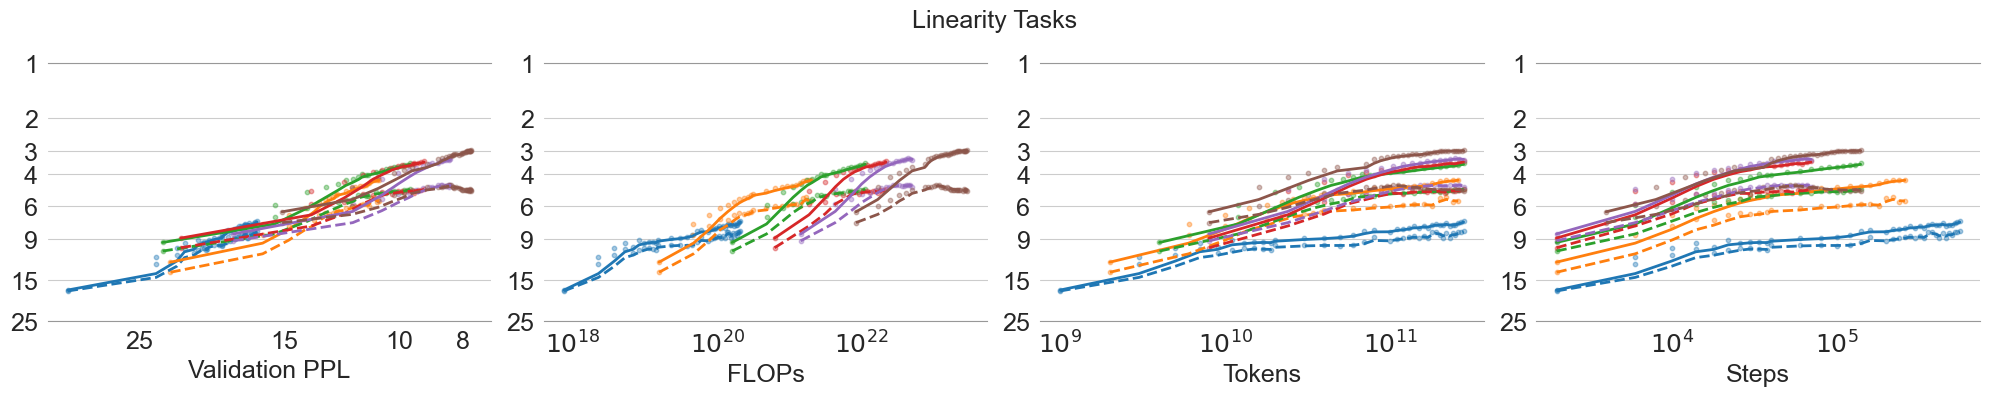

In [130]:
# plot accuracy vs. validation ppl, flops, tokens, steps

from utils import return_checkpoint_index, load_opt_validation_ppl, exponential_moving_average
validation_ppl = load_opt_validation_ppl()
 
colors = [plt.cm.tab20(i) for i in range(20)]
sns.set_style("whitegrid")

plot_types = ["Validation PPL", "FLOPs", "Tokens", "Steps"]
    
fig, axes = plt.subplots(1, len(plot_types), figsize=(5 * len(plot_types), 4))
fontsize = 18
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)

for plot_type_id, plot_type in enumerate(plot_types):
    max_x = 0 if plot_type != "Validation PPL" else 1e18
    ax = axes if len(plot_types) == 1 else axes[plot_type_id]
    if plot_type == "Validation PPL":
        ax.invert_xaxis()
    ax.invert_yaxis()
        
    for model_id, model_size in enumerate(result):
        xs = []; ys = []
        indexes = return_checkpoint_index(model_size)
        
        if plot_type == "FLOPs":
            xs = [result[model_size]["flops"][i] for i in indexes]
        elif plot_type == "Tokens":
            xs = [result[model_size]["tokens"][i] for i in indexes]
        elif plot_type == "Validation PPL":
            xs = [validation_ppl[model_size]["valid/combined"][i] for i in indexes]
        else:
            xs = indexes
        
        correct_ppl_ys = correct_option_ppls[model_size]
        incorrect_ppl_ys = incorrect_option_ppls[model_size]         

        if log_mode: xs = np.log10(xs); correct_ppl_ys = np.log10(correct_ppl_ys); incorrect_ppl_ys = np.log10(incorrect_ppl_ys)
        correct_ppl_ema_ys = exponential_moving_average(correct_ppl_ys, 0.5)
        incorrect_ppl_ema_ys = exponential_moving_average(incorrect_ppl_ys, 0.5)

        ax.plot(xs, correct_ppl_ema_ys, label=model_size, color=colors[model_id*2], linewidth=2)
        ax.scatter(xs, correct_ppl_ys, marker="o", alpha=0.4, color=colors[model_id*2], s=10)
        ax.plot(xs, incorrect_ppl_ema_ys, label=model_size, color=colors[model_id*2], linewidth=2, linestyle="--")
        ax.scatter(xs, incorrect_ppl_ys, marker="o", alpha=0.4, color=colors[model_id*2], s=10)
        
        ax.set_xlabel(plot_type, fontsize=fontsize)

        if model_id == 0:
            if plot_type == "Validation PPL": #  or type == "PPL of Options PPL":
                xs_ppl = [7, 8, 10, 15, 25]
                ax.set_xticks([np.log10(x) for x in xs_ppl], xs_ppl)
            if plot_type == "FLOPs":
                ax.set_xticks([18, 20, 22], ['$10^{18}$', '$10^{20}$', '$10^{22}$'], fontsize=fontsize)
            if plot_type == "Tokens":
                ax.set_xticks([9, 10, 11], ['$10^{9}$', '$10^{10}$', '$10^{11}$'], fontsize=fontsize)
            if plot_type == "Steps":
                ax.set_xticks([4, 5], ['$10^{4}$', '$10^{5}$'], fontsize=fontsize)
        
        if task_type == "breakthrough_tasks":
            option_ppl = [1, 2, 3, 4, 6, 9]
        elif task_type == "linearity_tasks":
            option_ppl = [1, 2, 3, 4, 6, 9, 15, 25]
        else:
            option_ppl = [1, 2, 3, 4, 6, 9]
        ax.set_yticks([np.log10(x) for x in option_ppl], option_ppl, fontsize=fontsize)
                     
        ax.yaxis.grid(True)
        sns.despine(left=True, bottom=False, top=False)
        ax.spines['top'].set_color('#989898')
        ax.spines['bottom'].set_color('#989898')
        ax.xaxis.grid(False)

if task_type == "breakthrough_tasks":
    figure_title = "Breakthrough Tasks"
elif task_type == "linearity_tasks":
    figure_title = "Linearity Tasks"
else:
    figure_title = "All Tasks"

fig.suptitle(figure_title, fontsize=fontsize)
plt.tight_layout()
# plt.savefig(f"images/bigbench_{'_'.join(figure_title.lower().split())}.pdf")

### Plot single task performance

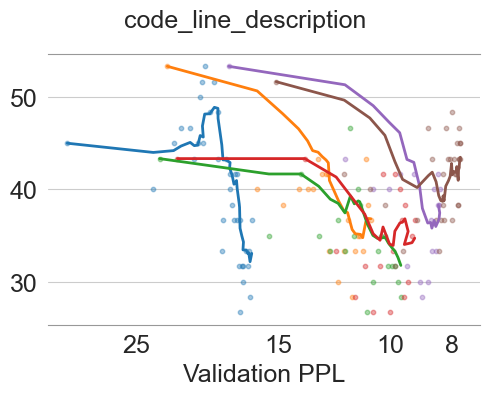

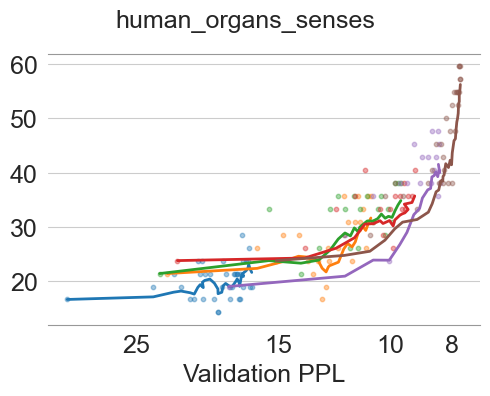

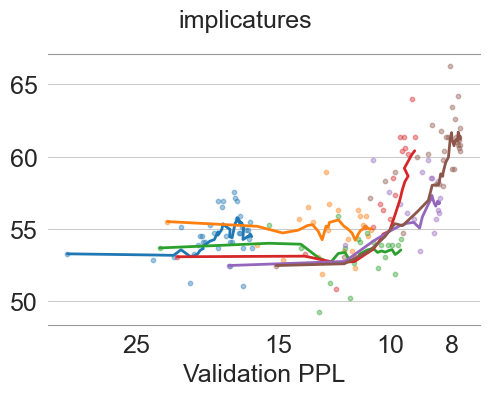

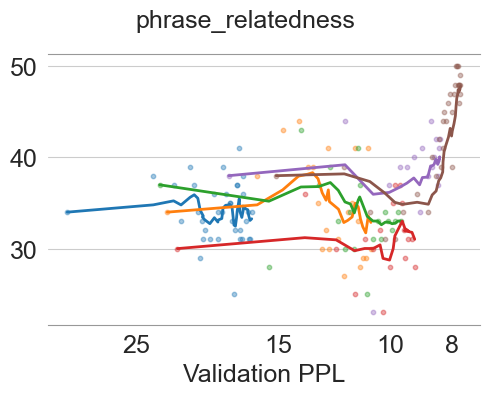

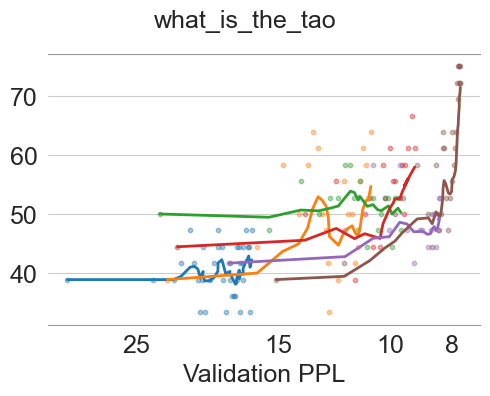

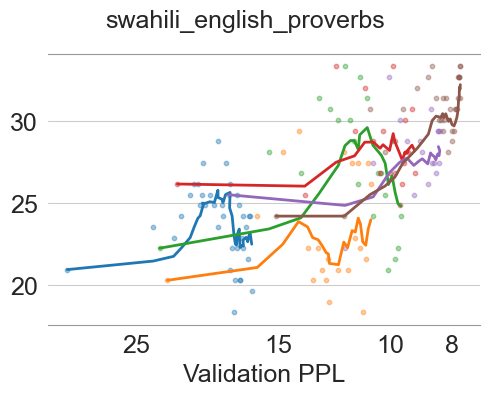

In [9]:
# plot accuracy vs. validation ppl, flops, tokens, steps

from utils import return_checkpoint_index, load_opt_validation_ppl, exponential_moving_average, bigbench_name_matching_dict
validation_ppl = load_opt_validation_ppl()
 
colors = [plt.cm.tab20(i) for i in range(20)]
sns.set_style("whitegrid")

plot_types = ["Validation PPL"] # , "FLOPs", "Tokens", "Steps"]
task_name_m = bigbench_name_matching_dict() 

for i in range(len(tasks)):
    fig, axes = plt.subplots(1, len(plot_types), figsize=(5 * len(plot_types), 4))
    fontsize = 18
    plt.rc('xtick', labelsize=fontsize)
    plt.rc('ytick', labelsize=fontsize)

    task_name = tasks[i]

    for plot_type_id, plot_type in enumerate(plot_types):
        max_x = 0 if plot_type != "Validation PPL" else 1e18
        ax = axes if len(plot_types) == 1 else axes[plot_type_id]
        if plot_type == "Validation PPL":
            ax.invert_xaxis()
            
        for model_id, model_size in enumerate(result):
            xs = []; ys = []
            indexes = return_checkpoint_index(model_size)
            
            if plot_type == "FLOPs":
                xs = [result[model_size]["flops"][i] for i in indexes]
            elif plot_type == "Tokens":
                xs = [result[model_size]["tokens"][i] for i in indexes]
            elif plot_type == "Validation PPL":
                xs = [validation_ppl[model_size]["valid/combined"][i] for i in indexes]
            else:
                xs = indexes
            
            ys = [result[model_size]["accuracy"][task_name][i] for i in indexes]

            if log_mode: xs = np.log10(xs); 
            ema_ys = exponential_moving_average(ys, 0.8)

            ax.plot(xs, ema_ys, label=model_size, color=colors[model_id*2], linewidth=2)
            ax.scatter(xs, ys, marker="o", alpha=0.4, color=colors[model_id*2], s=10)
            
            ax.set_xlabel(plot_type, fontsize=fontsize)

            if model_id == 0:
                if plot_type == "Validation PPL": #  or type == "PPL of Options PPL":
                    xs_ppl = [7, 8, 10, 15, 25]
                    ax.set_xticks([np.log10(x) for x in xs_ppl], xs_ppl)
                if plot_type == "FLOPs":
                    ax.set_xticks([18, 20, 22], ['$10^{18}$', '$10^{20}$', '$10^{22}$'], fontsize=fontsize)
                if plot_type == "Tokens":
                    ax.set_xticks([9, 10, 11], ['$10^{9}$', '$10^{10}$', '$10^{11}$'], fontsize=fontsize)
                if plot_type == "Steps":
                    ax.set_xticks([4, 5], ['$10^{4}$', '$10^{5}$'], fontsize=fontsize)
            
                        
            ax.yaxis.grid(True)
            sns.despine(left=True, bottom=False, top=False)
            ax.spines['top'].set_color('#989898')
            ax.spines['bottom'].set_color('#989898')
            ax.xaxis.grid(False)

    fig.suptitle(task_name_m[task_name], fontsize=fontsize)
    plt.tight_layout()
    plt.savefig(f"images/section3/{task_name}_ppl.pdf")